In [59]:
import pandas as pd
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import pathlib

### サンプルデータの作成　　
複数のデータセットを作成し,csvとしてローカルに保存する

In [315]:
df_meta = pd.DataFrame({'tar_NE':[1000,1000,1000,1000,1000], 'tar_GAIRCYL':[0.20,0.20,0.25,0.25,0.30 ], 'num':[1,2,1,2,3], 'file_name':['{}.csv'.format(i) for i in range(5)]})

In [316]:
df_meta.to_csv('meta.csv')

In [264]:
num_data =5
sampling = 0.01
data_list =[]

In [265]:
for i in range(num_data):
    time=np.arange(0,1000)*sampling
    signal = random.randn(1000)
    df = pd.DataFrame({'A':signal}, index = time)
    F_CH_rise = np.where(np.array(df.index)>5,1,0)
    F_CH_down = np.where(np.array(df.index)>3,0,1)
    df['F_V_rise'] = df.index.map(lambda x : 1 if ((x > 2)&(x<4))|((x > 7)&(x<8)) else 0 )
    df['F_V_down'] = df.index.map(lambda x : 0 if x > 3 else 1)
    data_list.append(df)

In [266]:
data_list[0]

,A,F_V_rise,F_V_down
0.00,-1.166060,0,1
0.01,0.098749,0,1
0.02,-0.075536,0,1
0.03,-0.777711,0,1
0.04,-0.237356,0,1
...,...,...,...
9.95,-1.862096,0,0
9.96,0.749452,0,0
9.97,0.447067,0,0
9.98,-1.300947,0,0


In [43]:
# INPUT DATAフォルダ作成
import os

try:
    os.mkdir('data')
except:
    pass

In [33]:
# OUTPUT DATAフォルダ作成
import os

try:
    os.mkdir('output')
except:
    pass

In [34]:
for i in range(num_data):
    data_list[i].to_csv('data/{}'.format(i)+'.csv')

### 条件のメタデータを準備

In [40]:
df_meta = pd.read_csv('meta.csv')

### 設定

In [31]:
#%matplotlib
#グラフを描画しない
%matplotlib inline
dt_ave_m = 1#移動平均時間
sampling = 0.01#データサンプリング時間
w_t = 5#指定領域の抽出
dt_d_max =1#最大変動量を算出するウィンドウ区間
df_meta_o = df_meta.copy()#出力用のメタファイルを作成
signal_name = 'A' #移動平均する信号
F_CH_name = 'F_V_rise' #データ抽出判定信号
criteria = 0.5 #立ち上がり判定用の値
F_CH_point = F_CH_name + '_point'
plot_sig = [signal_name + '_mean', F_CH_name]
y1_name = signal_name + '_mean'
y2_name = F_CH_name
x_name = 'Time'

### データを読み込み,最大最小値を抽出
+ dataフォルダに読み込むcsvファイルを用意する
+ jpegを出力するoutputフォルダを準備する

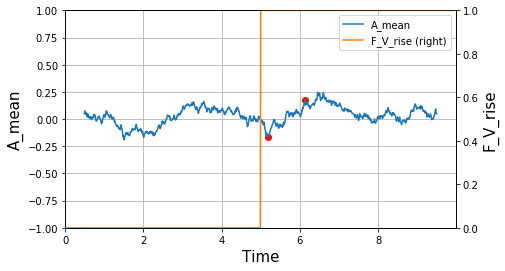

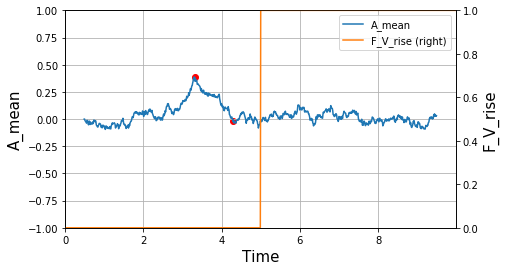

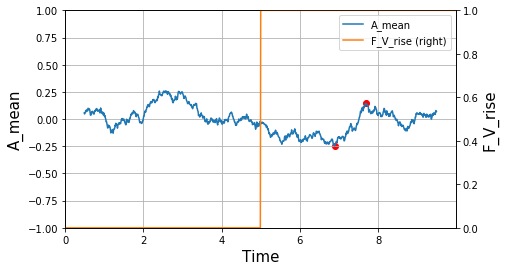

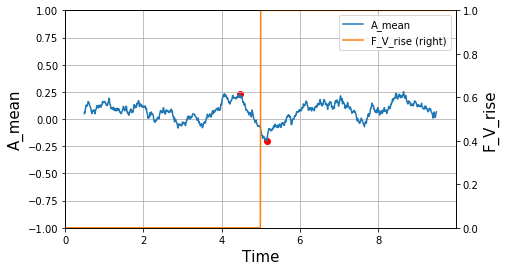

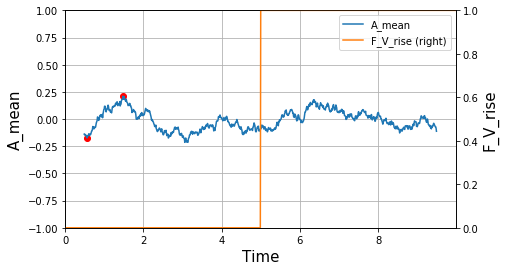

In [35]:
for path in pathlib.Path('data').glob('*.csv'):
    input_f = str(path.name)
    tar_NE = df_meta[df_meta['file_name']==input_f].tar_NE.values[0]
    tar_GAIRCYL = df_meta[df_meta['file_name']==input_f].tar_GAIRCYL.values[0]
    num = df_meta[df_meta['file_name']==input_f].num.values[0]
    output_f = str(tar_NE) + "_" + str(tar_GAIRCYL) + "_" + str(num)
    
    df = pd.read_csv(path, index_col =0)#データ読み込み
    df = ave_move(df, dt_ave_m, sampling, signal_name)#信号の移動平均算出
    df = detect_rise(df, F_CH_name, criteria)#立ち上がり検出
    #df = detect_down(df, F_CH_name, criteria)#立ち下がり検出
    df_W = window_data(df,w_t, F_CH_point)#検出ポイントの前後w_t区間を抽出
    #fig, spike_d = get_d_signal(df_W, dt_d_max, sampling, signal_name )
    spike_d = get_d_signal(df_W, dt_d_max, sampling, signal_name )
    
    df_meta_o.loc[df_meta_o['file_name']==input_f,'signal_d'] = spike_d[0]
    df_meta_o.loc[df_meta_o['file_name']==input_f,'min_v'] = spike_d[1]
    df_meta_o.loc[df_meta_o['file_name']==input_f,'max_v'] = spike_d[2]
    df_meta_o.loc[df_meta_o['file_name']==input_f,'min_t'] = spike_d[3]
    df_meta_o.loc[df_meta_o['file_name']==input_f,'max_t'] = spike_d[4]
    df_meta_o.loc[df_meta_o['file_name']==input_f,'jpeg_path'] = 'output/' + output_f + '.jpeg'
    fig = plot_signal(df_W, spike_d, plot_sig, y1_name, y2_name, x_name)
    output_jpeg('output/'+output_f, fig)

In [41]:
df_meta_o.to_csv("meta_jpeg.csv")

### エクセルファイルに画像ファイル出力
(引用) https://qiita.com/nshinya/items/a46ef0002284d2f77789

In [43]:
import pandas as pd
import openpyxl
from openpyxl.drawing.image import Image

df = pd.read_csv('meta_jpeg.csv', index_col=0)
# 3列目に画像のパスが入った列を挿入する。この列をテンプレート内でimgタグに変換する。
df.insert(0, "image", df["jpeg_path"])

# 画像埋め込み先の列
IMAGE_COL = "A"

# Excel変換
xl_path = "table.xlsx"
df.to_excel(xl_path, index=False)

# Excelロード
wb = openpyxl.load_workbook(xl_path)
# Activeシート取得
ws = wb.active

# 列幅を調整
for c in ws.columns:
    ws.column_dimensions['A'].width = 30

def image_column(worksheet, image_column):
    ws = worksheet

    # 列数を取得
    R_NUM = len(list(ws.rows))

    # 画像貼り付け
    # 行番号は1始まり。1行目はヘッダなので飛ばす
    for i in range(1, R_NUM):
        idx = i + 1
        cell_name = image_column + str(idx)
        c = ws[cell_name]
        try:
            # 画像ファイルのロード
            img = Image(c.value)
            # 画像の幅を200pxにする
            aspect = float(img.height) / img.width
            img.width = 200
            img.height = aspect * 200
            # 画像を貼り付ける
            ws.add_image(img, cell_name)
            # セルの高さを調整
            ws.row_dimensions[idx].height = img.height
            # セルの文字列は消しておく
            c.value = ""
        except FileNotFoundError:
            # 画像ファイルが見つからない場合はスキップ
            pass

image_column(ws, IMAGE_COL)

# 保存
wb.save(xl_path)

### 立上り検出

In [24]:
def detect_rise(df, signal_name, criteria):
    df[signal_name] = df[signal_name].map(lambda x: 1 if x >= criteria else 0)
    df[signal_name + '_point'] = df[signal_name].diff()==1
    return df

### 立ち下がり検出

In [25]:
def detect_down(df, signal_name, criteria):
    df[signal_name] = df[signal_name].map(lambda x: 1 if x >= criteria else 0)
    df[signal_name + '_point'] = df[signal_name].diff()==-1
    return df

### 移動平均を求める  
窓関数を適用し，その間にて，演算する  
(参考)https://note.nkmk.me/python-pandas-rolling/

In [26]:
def ave_move(df, dt, sampling, signal_name):
    n = int(dt / sampling)
    #df['F_CH_rise'] = df.F_CH.diff()==1
    df[signal_name + '_mean'] = df[signal_name].rolling(n, center = True).mean()
    return df

### 領域を指定しデータを抽出する  
（参考) https://note.nkmk.me/python-pandas-diff-pct-change/

In [27]:
def window_data(df, w_t, F_CH_rise):
    t_rise = df[df[F_CH_rise]].index.values[0]
    df['F_WINDOW'] = df.index.map(lambda x: True if (x <  w_t + t_rise) & (x > t_rise - w_t) else False )
    df_W = df[df['F_WINDOW']].copy()
    df_W.index = np.arange(0, df.F_WINDOW.sum())/100
    return df_W

### 最大値を抽出し、プロットする

In [28]:
def get_d_signal(df_W, dt, sampling, signal_name):
    n = int(dt / sampling)
    df_W[signal_name + '_max'] =df_W[signal_name + '_mean'].rolling(n, center=True).max()
    df_W[signal_name + '_min'] = df_W[signal_name + '_mean'].rolling(n, center= True).min()
    df_W[signal_name + '_delta'] = df_W[signal_name + '_max'] - df_W[signal_name + '_min']
    signal_dmax = np.nanmax(df_W[signal_name + '_delta'])
    df_W['F_' + signal_name + '_max_d'] =df_W[signal_name + '_delta'] .map(lambda x : 1 if x == signal_dmax else 0)
    pos_mm = df_W[df_W['F_' + signal_name + '_max_d'].diff().map(lambda x: abs(x)) == 1].index.values
    min_t = round(pos_mm[1] - dt/2 - sampling , 2)
    max_t = round(pos_mm[0] + dt/2- sampling , 2)
    min_value = df_W[df_W.index == min_t][signal_name + '_mean'].values[0]
    max_value = df_W[df_W.index == max_t][signal_name + '_mean'].values[0]
    return [signal_dmax, min_value, max_value, min_t, max_t]

In [29]:
def plot_signal(df_W, features_sig, plot_sig, y1_name, y2_name, x_name):
    #fig = plt.scatter([features_sig[3], features_sig[4]],[features_sig[1], features_sig[2]], color = 'red')
    fig = df_W[[i for i in plot_sig]].plot(secondary_y=[y2_name], figsize=(7,4),legend="best",grid=True)
    fig.scatter([features_sig[3], features_sig[4]],[features_sig[1], features_sig[2]], color = 'red')
    # 左y軸のラベル
    fig.set_ylabel(y1_name, fontsize=15)

    # 右y軸のラベル
    fig.right_ax.set_ylabel(y2_name, fontsize=15)

    # x軸のラベル
    fig.set_xlabel(x_name, fontsize=15)
    
    # 左y軸の描画範囲 余裕を持たせるために下限上限共に-1, +1
    fig.set_ylim(-1, 1)

    # 右y軸の描画範囲
    fig.right_ax.set_ylim(0,1)

    return fig


### 画像の出力

In [294]:
def output_jpeg(file_name, fig):
    fig.figure.savefig(file_name+'.jpeg')

In [7]:
df = data_list[0]

In [2]:
import pandas as pd
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import pathlib

In [46]:
def detect_rise(df, signal_name, criteria):
     """
    This function detect rising signal point and return the index.
    
    Args:
        df : dataframe which include time series data
        signal_name: The name of signal which is detected 
        criteria : The value for judging rising
    
    Returns:
        rise_time: list of time of signal rising
    """
    df[signal_name] = df[signal_name].map(lambda x: 1 if x >= criteria else 0)
    df[signal_name + '_point'] = df[signal_name].diff()==1
    rise_time = list(df.loc[df[signal_name + '_point']].index.values)
    return rise_time

In [57]:
a = detect_rise(df, 'F_V_rise', 0.5)

In [58]:
df.loc[df.index==a[0]]

,A,F_V_rise,F_V_down,F_V_rise_point
2.01,-0.440473,1,1,True


### 時系列データを扱う

In [313]:
#メタデータにて、テスト条件や集計前のRAWデータが保存されているファイル名を管理
df_meta

,tar_NE,tar_GAIRCYL,num,file_name
0,1000,0.10,1,0.csv
1,1000,0.20,1,1.csv
2,1000,0.25,1,2.csv
3,1000,0.25,2,3.csv
4,1000,0.30,3,4.csv


In [319]:
#各条件での比較を実施するため、比較するグループを作成
#下記では、tar_NEとtar_GAIRCYLが同じ条件での計測タイミング違いを比較する
df_g = df_meta.groupby(["tar_NE","tar_GAIRCYL"])

In [342]:
pd.read_csv("data/"+file[0])

0     -0.180332
1     -0.022288
2      1.843252
3      0.541434
4     -0.048732
         ...   
995   -0.488315
996   -0.190832
997   -1.121062
998    0.194649
999   -0.396598
Name: A, Length: 1000, dtype: float64

In [386]:
i[1][['num','file_name']]

,num,file_name
0,1,0.csv
1,2,1.csv


In [376]:
#複数の時系列データを比較する
para_list = ["A", "F_V_down"]
for i in df_g:
    df_list = []
    for j, m in i[1][['num','file_name']]:
        df_list.append(pd.read_csv("data/"+m, index=[[k + "_"+str(j.num) for k in para_list]])[para_list])
    df_all = pd.concat(df_list, axis =1)
    fig = plt.figure(figsize=(4,4))
    ax１ = fig.add_subplot(111)

ValueError: too many values to unpack (expected 2)

In [269]:
#保存データの条件
a=df_meta[['tar_NE', 'tar_GAIRCYL']]
para_g = []
for i in range(len(a)):
    para_g.append(tuple(a.iloc[i]))
para_g=tuple(set(para_g))

In [300]:
para_g

((1000, 1), (1000, 3), (1000, 2))

In [285]:
para_list[0]

,A,F_V_down
0,0.992606,1
1,1.393852,1
2,-0.590328,1
3,1.371711,1
4,0.614173,1
...,...,...
995,-0.843094,0
996,0.341967,0
997,0.130972,0
998,-0.152918,0


['0.csv' '1.csv']
['4.csv']
['2.csv' '3.csv']


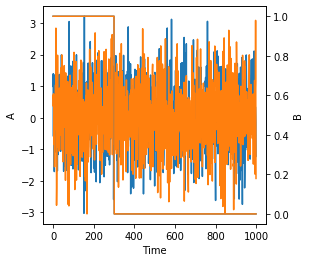

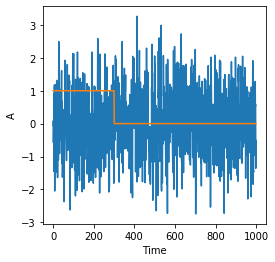

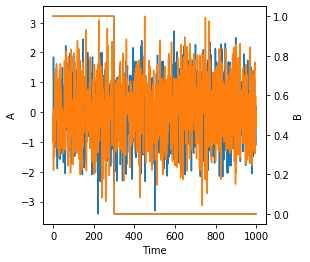

In [307]:
#グループごとにデータを読み込み可視化する。
for i in para_g:
    df_list = []
    para_list=[]
    file = df_g.get_group(i).file_name.values
    for j in range(len(file)):
        df_list.append(pd.read_csv("data/"+file[j]))
        para_list.append(df_list[j][["A", "F_V_down"]])
        para_list[j].columns= ["A"+str(j+1), "B"+str(j+1)]
    df_all = pd.concat(para_list,axis=1)
    fig = plt.figure(figsize=(4,4))
    ax１ = fig.add_subplot(111)
    print(file)
    
    if len(file) == 2:
        ax1.set_xlabel('Time')
        ax2 = ax1.twinx()
        ax1.set_ylabel("A")
        ax2.set_ylabel("B")
        ax1.plot(df_all[["A1","A2"]])
        ax2.plot(df_all[["B1","B2"]])
    
    else:
        ax1.set_xlabel('Time')
        ax1.set_ylabel("A")
        ax1.plot(df_all[["A1","B1"]])

    output_jpeg(str(i)+".csv", ax2)

In [295]:
def output_jpeg(file_name, fig):
    fig.figure.savefig(file_name+'.jpeg')

In [275]:
df_all

,A,B,C,D
0,-0.180332,1,-0.963470,1
1,-0.022288,1,-0.152604,1
2,1.843252,1,-1.955441,1
3,0.541434,1,0.110448,1
4,-0.048732,1,-0.394215,1
...,...,...,...,...
995,-0.488315,0,-0.654222,0
996,-0.190832,0,0.303469,0
997,-1.121062,0,0.526884,0
998,0.194649,0,-0.580432,0


In [ ]:
a = pd.concat([df1.A,df2.A,df1.F_V_down,df2.F_V_down],axis=1)

In [253]:
para_g = []
for i in range(len(a)):
    para_g.append(tuple(a.iloc[i]))

In [217]:

df1 = data_list[0]
df2 = data_list[1]

In [218]:
a = pd.concat([df1.A,df2.A,df1.F_V_down,df2.F_V_down],axis=1)

In [219]:
a.columns=['A', 'B','C','D']

KeyError: "None of [Index(['A', 'B'], dtype='object')] are in the [columns]"

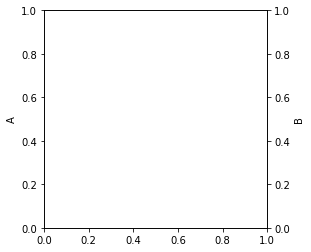

In [298]:

fig = plt.figure(figsize=(4,4))
ax１ = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.set_ylabel("A")
ax2.set_ylabel("B")
ax1.plot(a[["A","B"]])
ax2.plot(a[["C","D"]])





#fig.show()
#a.plot(secondary_y=['C','D'], ax = ax2)



#ax.set_ylabel("B")
# TITLEを設定
#ax.set_title("TEST")
# X軸の範囲
#ax.set_xlim(0,2*np.pi)
# Y軸の範囲
#ax.set_ylim(-1,1)
# X軸のTick（目盛）の位置を設定
#ax.set_xticks([0, np.pi, np.pi*2])
# X軸のTick（目盛）の表記を設定
#ax.set_xticklabels([0, 'π', '2π'])
# Y軸のTick（目盛）の位置を設定
#ax.set_yticks([-1, -0.5, 0, 0.5, 1])
# X軸のラベルを設定
#ax.set_label('X [RAD]')
# グラフ表示
plt.show()

In [221]:
df_g = df_meta.groupby(["tar_NE","num"])

In [222]:
df_g.get_group((1000,1)).file_name

0    0.csv
1    1.csv
Name: file_name, dtype: object

In [223]:
df_g

In [317]:
df_meta

,tar_NE,tar_GAIRCYL,num,file_name
0,1000,0.20,1,0.csv
1,1000,0.20,2,1.csv
2,1000,0.25,1,2.csv
3,1000,0.25,2,3.csv
4,1000,0.30,3,4.csv


0    0.csv
Name: file_name, dtype: object
1    1.csv
Name: file_name, dtype: object
2    2.csv
Name: file_name, dtype: object
3    3.csv
Name: file_name, dtype: object
4    4.csv
Name: file_name, dtype: object


In [204]:
a=df_meta[['tar_NE', 'num']]

In [225]:
a

,A,B,C,D
0.00,0.534760,1.037240,1,1
0.01,0.549816,-1.416218,1,1
0.02,-1.561000,-0.858397,1,1
0.03,0.390466,1.424585,1,1
0.04,1.507921,-1.373419,1,1
...,...,...,...,...
9.95,-0.551447,-0.608052,0,0
9.96,1.306547,0.742902,0,0
9.97,-0.131235,-0.106566,0,0
9.98,-0.875421,-0.721055,0,0


In [211]:
para_g = []
for i in range(len(a)):
    para_g.append(tuple(a.iloc[i]))

In [215]:
para_g=tuple(set(para_g))

In [216]:
for i in para_g:
    print(df_g.get_group(i).file_name)

0    0.csv
1    1.csv
Name: file_name, dtype: object
4    4.csv
Name: file_name, dtype: object
2    2.csv
3    3.csv
Name: file_name, dtype: object


In [ ]:
para_g = []
tar_GAIRCYL = [0.1, 0.15, 0.20, 0.25, 0.30]
num = [1,2,3]
for i in tar_GAIRCYL:
    for j in num:
        para_g.append((i,j))